In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls '/content/drive'

Mounted at /content/drive
MyDrive  Shareddrives


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os

'''
I used a slightly modified version of NaiveBayes classifier from AS1 here

'''

class MyBayesClassifier():
    def __init__(self, smooth=1):
        self._smooth = smooth # This is for additive smoothing
        

    def train(self, X, y):
        alpha_smooth = self._smooth
        cls = np.unique(y)
        Ncls, Nfeat = len(cls), X.shape[1] #Ncls: number of classes, Nfeat: number of features.

        self._cls = cls
        self._prior = np.zeros((1,Ncls))
        #initialize a matrix stand for all p(x|y),the likelyhood for every attribute
        self._likehood = np.zeros((Ncls,Nfeat))
        #for each class,find rows that satisfies the condition,and compute the likehood of each feature
        for i in range(Ncls):
            cla = cls[i]
            x_cla = X[y==cla]                                              #the rows that belong to current class
            self._prior[0,i] =(x_cla.shape[0]+alpha_smooth)/(X.shape[0]+alpha_smooth*Ncls)                    #compute prior probability of current class
            #self._likehood[i] = np.sum(x_cla,axis=0)/x_cla.shape[0]       #verticlly summation along each column to get frequency of each feature and then divide by # of rows

            self._likehood[i,:] = (np.sum(x_cla, axis=0)+alpha_smooth) / (x_cla.shape[0]+ alpha_smooth * 2)                  #apply smooth to frequency divide # of rows
            #print(self._likehood)
            #print(self._prior)

    def train_JM_smooth(self, X, y,X_dataset):
        alpha_smooth = self._smooth
        cls = np.unique(y)
        Ncls, Nfeat = len(cls), X.shape[1] #Ncls: number of classes, Nfeat: number of features.

        size_dataset = X_dataset.shape[0]             #number of data in dataset
        feature_dataset = np.sum(X_dataset,axis=0)    #count the appearnce of each word in dataset by verticlly sum along each column from the dataset


        self._cls = cls
        self._prior = np.zeros((1,Ncls))
        #initialize a matrix stand for all p(x|y),the likelyhood for every attribute
        self._likehood = np.zeros((Ncls,Nfeat))
        #for each class,find rows that satisfies the condition,and compute the likehood of each feature
        for i in range(Ncls):
            cla = cls[i]
            x_cla = X[y==cla]                                              #the rows that belong to current class
            self._prior[0,i] =x_cla.shape[0]/X.shape[0]                    #compute prior probability of current class
            #self._likehood[i] = np.sum(x_cla,axis=0)/x_cla.shape[0]       #verticlly summation along each column to get frequency of each feature and then divide by # of rows
            numerator1 = np.sum(x_cla, axis=0)
            denominator1 = np.sum(x_cla)

            self._likehood[i,:] = (1- alpha_smooth)*numerator1/denominator1 + alpha_smooth * feature_dataset / size_dataset                  #apply JM smooth to frequency divide # of rows

        #after the for loop,self._prior stores the prior probability of all catergories and
        #selef._likehood stores the probabality of all feature  such that  P(feature_i | catergory)
            ###confusion  : smoothing????????
        #self._notlikehood = 1-self._likehood              #P(not feature i | catergory )
    def predict(self, X):

        Ncls,Ntest,Nfeat = len(self._cls),X.shape[0],X.shape[1]                         #number of test sample
        pred = np.zeros(Ntest)
        loglikehood = np.log(self._likehood)       
        X_not = 1-X                   #since in original data,1 for appearence of feature i and 0 for not appear,the logic not means 1 for not appear and 0 for appear

        #X is size Ntest x Nfeat,selef._likehood.T is the shape Nfeat x Ncls
        log_appear = X.dot(np.log(self._likehood.T))
        
        #print("appear",log_appear)
        
        log_absence = X_not.dot (np.log(1-self._likehood.T))
        #print("absence",log_absence)

        log_post = log_appear+log_absence
        #log_post = X.dot(np.log(self._likehood.T)) + X_not.dot (np.log(1-self._likehood.T))    #consider both appearence and absence
        #log_post = X.dot(np.log(self._likehood.T))                                             #only consider appearence

        log_post = log_post + np.log(self._prior.reshape(1,Ncls))
        #print(log_post)
        pred = self._cls[np.argmax(log_post,axis=1)]

        return pred




In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import plotly
import seaborn as sns



'''
use this part if you have upload the data to github
'''
#url = 'http:~~~~~~~~~~~~~~~~~~~~~/mbti_1.csv'
#df = pd.read_csv(url,)

df = pd.read_csv('/content/drive/MyDrive/CMPUT466/groupProj/mbti_1.csv',header=0)
df.head(10)

#df = pd.read_csv('/content/drive/MyDrive/CMPUT466/groupProj/mbti_full_pull.csv')
#df.head()


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
5,INTJ,'18/37 @.@|||Science is not perfect. No scien...
6,INFJ,"'No, I can't draw on my own nails (haha). Thos..."
7,INTJ,'I tend to build up a collection of things on ...
8,INFJ,"I'm not sure, that's a good question. The dist..."
9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...


<Figure size 3600x1440 with 0 Axes>

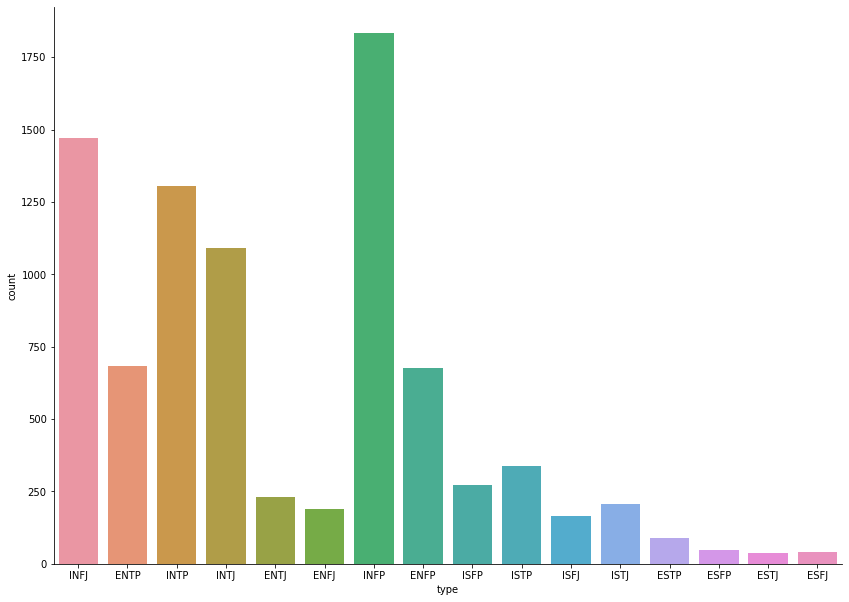

In [ ]:
fig = plt.gcf()
fig.set_size_inches(50, 20)
sns.catplot(x="type", kind="count", data=df,height=8.27, aspect=11.7/8.27)


In [ ]:
#
# Just striping the string incase of any whitespace before or after the string
df["type"] = df["type"].str.strip()
# Seperate the the label into four different parts
target_multi_label = df["type"].str.split("" , expand=True)
target_multi_label = target_multi_label.iloc[: , 1:-1]
target_multi_label.columns = ["Personality-1","Personality-2","Personality-3","Personality-4"]

df = pd.concat([df,target_multi_label] , axis=1)
'''
personality_map = {
    "I":"Introvert",
    "E":"Extrovert",
    "N":"Intuitive",
    "S":"Sensitive",
    "F":"Emotional",
    "T":"Thinker",
    "J":"Judgemental",
    "P":"Perceiving"
}
for col in df.loc[: , "Personality-1":"Personality-4"].columns:
    df[col] = df[col].map(personality_map)
'''
df.head()



,type,posts,Personality-1,Personality-2,Personality-3,Personality-4
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J


<Figure size 3600x1440 with 0 Axes>

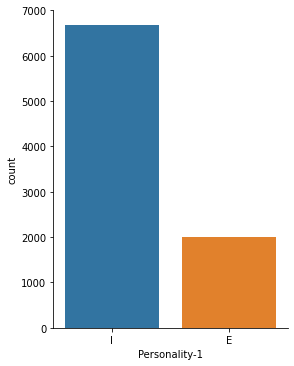

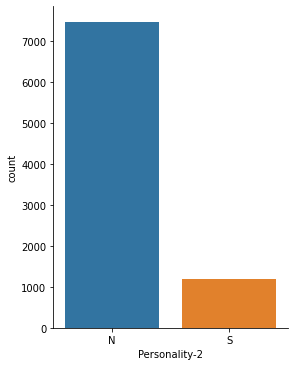

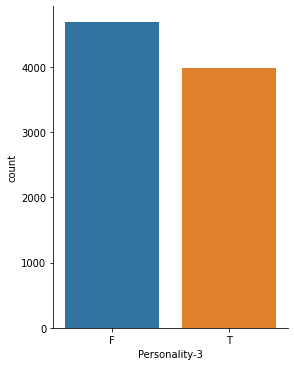

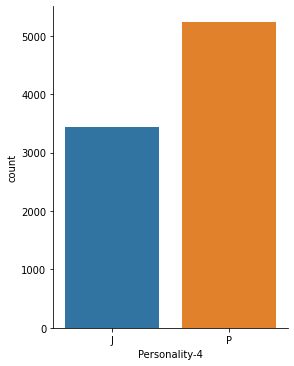

In [ ]:
fig = plt.gcf()
fig.set_size_inches(50, 20)
sns.catplot(x="Personality-1", kind="count", data=df,height=5, aspect=4/5)
sns.catplot(x="Personality-2", kind="count", data=df,height=5, aspect=4/5)
sns.catplot(x="Personality-3", kind="count", data=df,height=5, aspect=4/5)
sns.catplot(x="Personality-4", kind="count", data=df,height=5, aspect=4/5)


In [ ]:
#version1 of text pre-processing

#source:https://towardsdatascience.com/nlp-text-preprocessing-a-practical-guide-and-template-d80874676e79
!pip install Unidecode
!pip install contractions
import nltk
nltk.download('wordnet')

from bs4 import BeautifulSoup
import spacy
import unidecode 
#from word2number import w2n
import contractions
from nltk.stem import WordNetLemmatizer 
import re

def preprocessing_v1(text):
    #remove html information
    soup = BeautifulSoup(text, "html.parser")
    processed = soup.get_text(separator=" ")
    
    #remove http// 
    processed = re.sub(r"http\S+", "", processed)

    #remove ||| seperate
    processed = re.sub(r'\|\|\|', r' ', processed)

    #lower case
    processed = processed.lower()

    #expand shortened words, e.g. don't to do not
    processed = contractions.fix(processed)

    #remove accented char
    processed = unidecode.unidecode(processed)

    #remove white space
    #processed = processed.strip()
    #processed = " ".join(processed.split())

    # Lemmatizing 
    lemmatizer = WordNetLemmatizer() 
    processed=lemmatizer.lemmatize(processed)


    return processed

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df['posts'] = df['posts'].apply(preprocessing_v1)
df.head()

,type,posts,Personality-1,Personality-2,Personality-3,Personality-4
0,INFJ,' and intj moments sportscenter not top ten...,I,N,F,J
1,ENTP,'I am finding the lack of me in these posts ve...,E,N,T,P
2,INTP,"'good one _____ course, to which i say i k...",I,N,T,P
3,INTJ,"'dear intp, i enjoyed our conversation the o...",I,N,T,J
4,ENTJ,'you are fired. that is another silly misconce...,E,N,T,J


In [ ]:
#split traning and test data and vectorize them



number_training = 6000
data_size = df['type'].shape[0]



all_data = df['posts'].astype('U').values
data_train = df['posts'][:number_training].astype('U').values
data_test = df['posts'][number_training:].astype('U').values

y_train = df['type'][:number_training].astype('U').values
y_test = df['type'][number_training:].astype('U').values


#Note here, increase max_features may result in increasing ram usage and cause crush of colab
#By defaut,it will geneate over 140000 features without any text preprocessing,it would decrease to near 100000 but still not acceptable
#therefore I added a upper bound for max_features
vectorizer = CountVectorizer(
        lowercase=True, stop_words='english',
        max_df=1.0, min_df=1, max_features=2000,  binary=True
      )
processed_data = vectorizer.fit_transform(all_data).toarray()

X_train = processed_data[0:number_training, :]
X_test = processed_data[number_training:, :]

print("X_train.shape = {}".format(X_train.shape))
print("X_test.shape = {}".format(X_test.shape))


X_train.shape = (6000, 2000)
X_test.shape = (2675, 2000)


In [ ]:
####   tempoary test cell , only used to debug some non-sense
print(X_train)
print(sum(X_train[0]))

[[0 0 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 0 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]
150


In [ ]:
#perform naive bayes,predict 1 among 16 personality types at once
clf = MyBayesClassifier(1.0)
clf.train(X_train, y_train);
y_pred = clf.predict(X_test)
print("Absolute accuracy = {}".format(np.mean(y_test==y_pred)))



Absolute accuracy = 0.44897196261682243


In [ ]:
#for each sub-personality type,train the model and make prediction
#first test I/E,then N/S.......Cancadinate the result together to form final result
y_pred = a2 = np.array(['' for i in range(data_size-number_training)])
print(y_pred.shape)
print(type(y_pred))
clf = MyBayesClassifier(1.0)

for col in df.loc[: , "Personality-1":"Personality-4"].columns:
    y_train_sub = df[col][:6000].astype('U').values
    clf.train(X_train, y_train_sub);
    y_pred_sub = clf.predict(X_test)

    y_pred=np.core.defchararray.add(y_pred, y_pred_sub)

print(y_pred)
print(y_test)
print("Absolute accuracy = {}".format(np.mean(y_test==y_pred)))


(2675,)
<class 'numpy.ndarray'>
['INFP' 'ENFJ' 'INTP' ... 'INTP' 'INFJ' 'INFP']
['INFP' 'INFJ' 'INTP' ... 'INTP' 'INFP' 'INFP']
Absolute accuracy = 0.3390654205607477


In [ ]:
'''
Need to seperate out the smoothing with the training in order to implement cross validation
'''
class MyBayesClassifier():
    def __init__(self, smooth=1):
        self._smooth = smooth # This is for additive smoothing
        self._p_y = None #p(y=True)
        self._features_num =  None  #numerator for probabilities of words
        self._prior_num = np.zeros((16,1)) #numerator for the probability of the apriori. Which is the count of the labels
    def _count_features(self,data,label):
        self._features_num[label] += data
        self._prior[label] += 1
    def train(self, X, y):
        cls = np.unique(y)
        Ncls, Nfeat = len(cls), X.shape[1] #Ncls: number of classes, Nfeat: number of features.
        cls_vec = np.reshape(y,(len(y),1))
        self._feature_num = np.zeros((16,Nfeat))
        store_features = np.vectorize(self.count_features)
        store_features(X,y)
        '''
        this is the matrix multiplication solution not sure if its faster
        for i in range(16):
          # this will loop over the 16 possible classes
          x_cla = X[y==i]
          one_vec = np.ones((1,x_cla.shape[0]))
          self._features_num[i] = (np.matmul(one_vec,x_cla))
          self._features_den[i] = x_cla.shape[0]
          #self._features[i] = {"num":(np.matmul(one_vec,x_cla)),"den": x_cla.shape[0]}
          #self._prior[i] = {"num":x_cla.shape[0],"den":X.shape[0]}
        '''
    def change_smooth(self,new_alpha):
        self._smooth = new_alpha
    def _compute_prediction(self,data_point):
        '''
        precondition: datapoint must be a list of integers that are either 0 or 1. And its length must be the same as the number of features.
        postcondition: no side effects
        this will return an array of 16 floats [0,1] each corresponding to one of the possible personality types
        '''
        prob_matrix = (self._features_num + self.smooth)/(self._prior_num + self.smooth*2)
        data_point_matrix = np.array([data_point,]*prob_matrix.shape[0])
        true_matrix = data_point_matrix * prob_matrix
        false_matrix = ((data_point_matrix+1)%2) * (1-prob_matrix)
        return (np.squeeze(np.matmul(np.log(true_matrix+false_matrix),np.ones((true_matrix.shape[0],1))))*np.log((self._prior+self._smooth)/(16*self._smooth+sum(self._prior))))
    def predict(self, X):
        get_pred = np.vectorize(self._compute_prediction)
        result = get_pred(X)
        pred = np.argmax(axis=1)
        return 
#split traning and test data and vectorize them



number_training = 6000
data_size = df['type'].shape[0]



all_data = df['posts'].astype('U').values
data_train = df['posts'][:number_training].astype('U').values
data_test = df['posts'][number_training:].astype('U').values

y_train = df['type'][:number_training].astype('U').values
y_test = df['type'][number_training:].astype('U').values


#Note here, increase max_features may result in increasing ram usage and cause crush of colab
#By defaut,it will geneate over 140000 features without any text preprocessing,it would decrease to near 100000 but still not acceptable
#therefore I added a upper bound for max_features
vectorizer = CountVectorizer(
        lowercase=True, stop_words='english',
        max_df=1.0, min_df=1, max_features=2000,  binary=True
      )
processed_data = vectorizer.fit_transform(all_data).toarray()

X_train = processed_data[0:number_training, :]
X_test = processed_data[number_training:, :]

print("X_train.shape = {}".format(X_train.shape))
print("X_test.shape = {}".format(X_test.shape))

clf = MyBayesClassifier(1.0)
clf.train(X_train, y_train);
y_pred = clf.predict(X_test)
print("Absolute accuracy = {}".format(np.mean(y_test==y_pred)))